In [2]:
import sys
sys.path.insert(1,'../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
from data.dataloader import ImageNetA, get_dataloader

from data.datautils import PatchAugmenter
from model.custom_clip import get_coop
from utils.utils import set_random_seed, show, show_patches

import torch.backends.cudnn as cudnn
import torch
import numpy as np
from tqdm import tqdm
from copy import deepcopy

In [4]:
usefull = torch.tensor(1)

In [5]:
def select_confident_samples(logits, top):
    batch_entropy = -(logits.softmax(1) * logits.log_softmax(1)).sum(1)
    idx = torch.argsort(batch_entropy, descending=False)[
        : int(batch_entropy.size()[0] * top)
    ]
    return logits[idx]

def avg_entropy(outputs):
    logits = outputs - outputs.logsumexp(
        dim=-1, keepdim=True
    )  # logits = outputs.log_softmax(dim=1) [N, 1000]
    avg_logits = logits.logsumexp(dim=0) - np.log(
        logits.shape[0]
    )  # avg_logits = logits.mean(0) [1, 1000]
    min_real = torch.finfo(avg_logits.dtype).min
    avg_logits = torch.clamp(avg_logits, min=min_real)
    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1)

def selective_entropy_loss(outputs, entropy_threshold=0.5):
    # Step 1: Average class distributions across augmentations for each patch
    avg_logits_per_patch = outputs.logsumexp(dim=1) - np.log(outputs.shape[1])  # Shape: [patch, classes]
    
    # Step 2: Calculate entropy for each patch
    avg_logits_per_patch = torch.clamp(avg_logits_per_patch, min=torch.finfo(avg_logits_per_patch.dtype).min)
    entropy_per_patch = -(avg_logits_per_patch * torch.exp(avg_logits_per_patch)).sum(dim=-1)  # Shape: [patch]
    
    # Step 3: Define the loss conditionally based on entropy threshold
    # 3a: Force consistency between patches if entropy across patches is high
    if entropy_per_patch.mean() > entropy_threshold:
        # Minimize variance or KL divergence between patches
        consistency_loss = 0
        for i in range(avg_logits_per_patch.shape[0] - 1):
            for j in range(i + 1, avg_logits_per_patch.shape[0]):
                consistency_loss += torch.nn.functional.kl_div(
                    avg_logits_per_patch[i].log_softmax(dim=0), avg_logits_per_patch[j].softmax(dim=0), reduction="batchmean"
                )
        consistency_loss /= avg_logits_per_patch.shape[0] * (avg_logits_per_patch.shape[0] - 1) / 2
        return consistency_loss
    
    # 3b: Otherwise, target only patches with high entropy
    else:
        high_entropy_patches = entropy_per_patch > entropy_threshold
        selective_entropy_loss = entropy_per_patch[high_entropy_patches].mean()
        return selective_entropy_loss

# n_aug = 2, n_patches = 2, 
# torch.Size([13, 200]): [orig_img, patch1, patch1_aug1, patch1_aug2, patch1_aug3, ... , patch4_aug1, patch4_aug2, patch4_aug3]
# return 
# torch.Size([5, 3, 200])
def reshape_output_patches(output, n_aug):
    first_tensor_repeated = output[0].repeat(n_aug, 1)  # Repeat the first tensor 
    output = torch.cat((first_tensor_repeated, output), dim=0)
    return output
    # a = tt.view(-1, n_patches+1, 200)
    # b = tt.view(-1, n_aug+1, 200)
    # assert(torch.equal(a, b))

def test_time_tuning(
    model, n_aug, n_patches, inputs, optimizer, scaler, tta_step=1, selection_p=0.1
):
    for _ in range(tta_step):
        with torch.cuda.amp.autocast():
            output = model(inputs)
            output = reshape_output_patches(output, n_aug)
            loss = selective_entropy_loss(output)
            # output = select_confident_samples(output, selection_p)
            #loss = avg_entropy(output)
            

        optimizer.zero_grad()
        # compute gradient and do SGD step
        scaler.scale(loss).backward()
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.step(optimizer)
        scaler.update()

    return



def test_time_adapt_eval(
    dataloader, model, n_aug, n_patches, optimizer, optim_state, scaler, device
):
    samples = 0.0
    cumulative_accuracy_base = 0.0
    cumulative_accuracy_tpt = 0.0

    model.eval()
    with torch.no_grad():
        model.reset()

    print("Test Time Evaluation")


    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (imgs, target) in progress_bar:
        images = torch.cat(imgs, dim=0).to(device)
        # images = torch.cat(imgs[1:], dim=0).to(device)  # don't consider original image
        orig_img = imgs[0].to(device)
        target = target.to(device)

        with torch.no_grad():
            model.reset()
        optimizer.load_state_dict(optim_state)

        with torch.no_grad():
            with torch.cuda.amp.autocast():
                output = model(orig_img)
        pred_base_conf, pred_base_class = torch.softmax(output, dim=1).max(1)

        test_time_tuning(model, n_aug, n_patches, images, optimizer, scaler)

        with torch.no_grad():
            with torch.cuda.amp.autocast():
                output = model(orig_img)
        pred_tpt_conf, pred_tpt_class = torch.softmax(output, dim=1).max(1)

        cumulative_accuracy_base += pred_base_class.eq(target).sum().item()
        cumulative_accuracy_tpt += pred_tpt_class.eq(target).sum().item()
        samples += 1

        curr_base_acc = (cumulative_accuracy_base / samples) * 100
        curr_TPTcoop_acc = (cumulative_accuracy_tpt / samples) * 100

        progress_bar.set_postfix(
            {
                "Base Acc": f"{curr_base_acc:.2f}%",
                "TPT Acc": f"{curr_TPTcoop_acc:.2f}%",
            }
        )

    return cumulative_accuracy_tpt / samples * 100

In [6]:
ImageNetA_path="../../Datasets/imagenet-a/"
coop_weight_path="../../model.pth.tar-50"
n_aug=2
n_patches=2
batch_size=1
arch="RN50"
device="cuda:0"
# device="cpu",
learning_rate=5e-3
weight_decay=0.0005
momentum=0.9
n_ctx=4
ctx_init=""
class_token_position="end"
csc=False

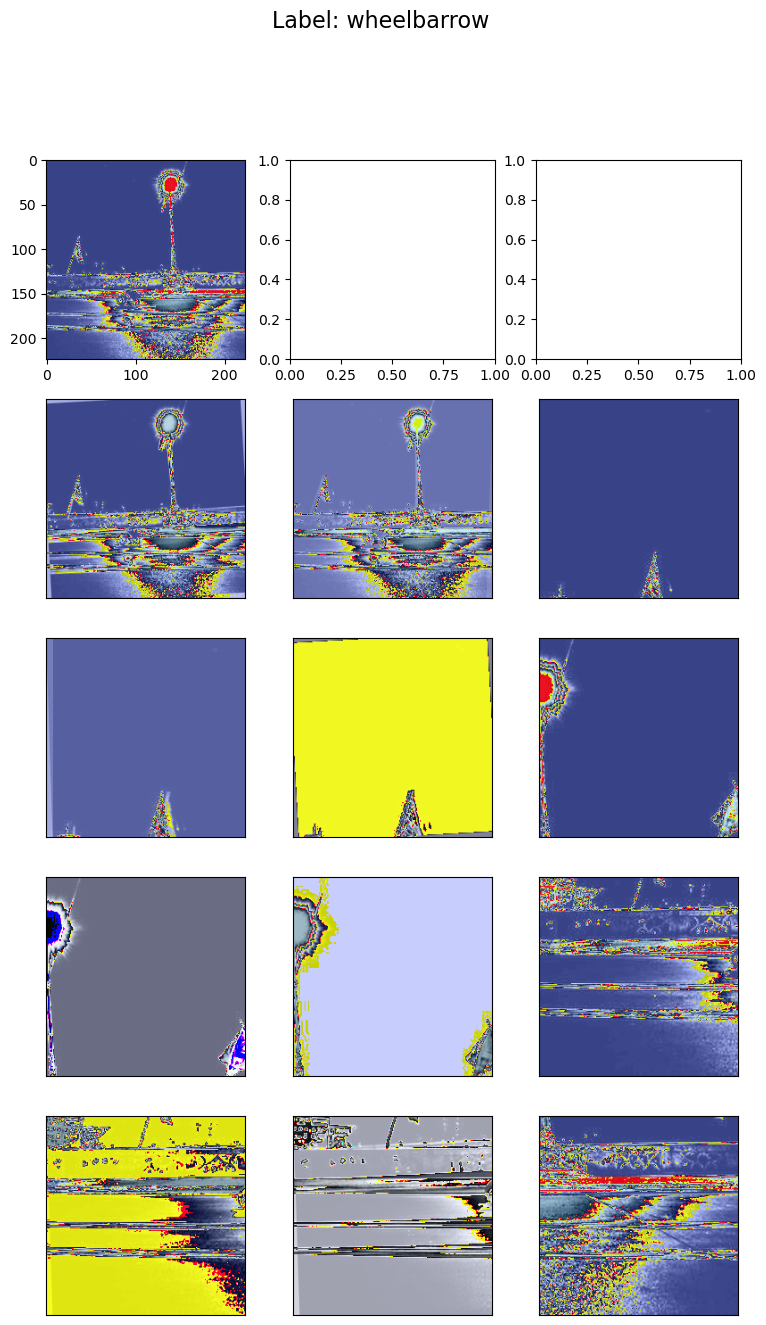

In [7]:
set_random_seed(1234)

classnames = ImageNetA.classnames

augmenter = PatchAugmenter(n_aug=n_aug, n_patches=n_patches)

dataset = ImageNetA(ImageNetA_path, transform=augmenter)
dataloader = get_dataloader(
    dataset, batch_size, shuffle=True, reduced_size=10, num_workers=1
)

(imgs, label) = next(iter(dataloader))

show_patches(imgs, label=classnames[label], n_aug=n_aug, n_patches=n_patches)

In [8]:

model = get_coop(arch, classnames, device, n_ctx, ctx_init)
print("Use pre-trained soft prompt (CoOp) as initialization")
pretrained_ctx = torch.load(coop_weight_path)["state_dict"]["ctx"]
with torch.no_grad():
    model.prompt_learner.ctx.copy_(pretrained_ctx)
    model.prompt_learner.ctx_init_state = pretrained_ctx

for name, param in model.named_parameters():
    if "prompt_learner" not in name:
        param.requires_grad_(False)

model = model.to(device)

trainable_param = model.prompt_learner.parameters()
optimizer = torch.optim.AdamW(trainable_param, learning_rate)
optim_state = deepcopy(optimizer.state_dict())
scaler = torch.cuda.amp.GradScaler(init_scale=1000)

cudnn.benchmark = True
model.reset_classnames(classnames, arch)


100%|███████████████████████████████████████| 244M/244M [00:18<00:00, 13.9MiB/s]


torch.float32
Random initialization: initializing a generic context
Initial context: "X X X X"
Number of context words (tokens): 4
Use pre-trained soft prompt (CoOp) as initialization


In [9]:
result = test_time_adapt_eval(
    dataloader,
    model,
    n_aug,
    n_patches,
    optimizer,
    optim_state,
    scaler,
    device,
)
print(result)

Test Time Evaluation


100%|██████████| 10/10 [00:05<00:00,  1.68it/s, Base Acc=10.00%, TPT Acc=10.00%]

10.0
